# NFT交換アプリによるソーシャルネットワークの分析
## 手法
1. 仮想のソーシャルネットワークの生成
    - NFTを渡す
    - NFTを返す
2. 有向グラフから無向グラフへ変換(オーソリティー信用性)
3. 中心性を求める
4. 中心性からスコア順に並べる

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import pandas as pd
from random import random
from networkx.algorithms.community import greedy_modularity_communities

## ①頂点への属性割り当て

### 頂点の用意
- 頂点数：300
- 高信頼者の割合：70%
- データフォーマット
    - trust：1=高信頼者、0=低信頼者
    - group：所属しているグループやコミュニティ(0~3グループ)
    - nft：関心のあるNFTの種類(0~4)

In [2]:
n = 1500
trust_p = 0.5
group_p = 0.25
nft_p = 0.2
color = ["blue", "red", "green", "yellow", "orange"]

In [3]:
trust_list = list()
group_list = list()
nft_list = list()

for i in range(1, n+1):

    # 信頼度の割り当て
    if random() < trust_p:
        trust_list.append(1)
    else:
        trust_list.append(0)

    # グループの割り当て(0~3)
    group = random() / group_p
    group_list.append(int(group))

    # 興味のあるNFTの割り当て(0~4)
    nft = random() / nft_p
    nft_list.append(int(nft))

    # 興味のない


In [4]:
data = [[] for i in range(n)]
for i, (t, g, n) in enumerate(zip(np.array(trust_list), np.array(group_list), np.array(nft_list))):
    data[i] = [t, g, n, 0.0, 0.0, 0.0]

In [5]:
df = pd.DataFrame(data=data, columns=["trust", "group", "nft", "次数中心性", "媒介中心性", "PageRank"])
print(f"頂点数：{len(df)}")
df.head()

頂点数：1500


trust  group  nft  次数中心性  媒介中心性  PageRank
0      0      3    2    0.0    0.0       0.0
1      1      2    1    0.0    0.0       0.0
2      1      1    0    0.0    0.0       0.0
3      1      2    2    0.0    0.0       0.0
4      1      3    3    0.0    0.0       0.0

## ②グラフの用意
0. グラフの初期化して10%の頂点を追加する
1. 完全グラフを作成して2~3を頂点を繰り返す
2. 頂点を追加する
3. 以下の確率関数$ P(j) $をもとにスケールフリー性を設定する
    - $ n $ ：頂点数
    - $ j $ ：頂点番号
    - $ d_j$：jの次数
$$
    P(j) = \frac{d_j} {\sum_{i=0}^{n}d_n}
$$

In [6]:
# グラフの初期化
n = len(df)
G = nx.DiGraph()
init_number_nodes = int(n * 0.1)
G.add_nodes_from([i for i in range(init_number_nodes)])
ps = [0 for i in range(n)]

# 完全グラフの作成
for i in range(init_number_nodes):
    G.add_edge(i, (i+1)%init_number_nodes)
    G.add_edge(i, (i+2)%init_number_nodes)

# 確率で追加する
for i in range(n):
    G.add_node(i)
    
    for j in range(G.number_of_nodes()):
        if i == j:
            continue

        p = (G.degree(j)) / (G.number_of_edges())
        
        if (p > random()):
            G.add_edge(i, j)
        ps[i] = p


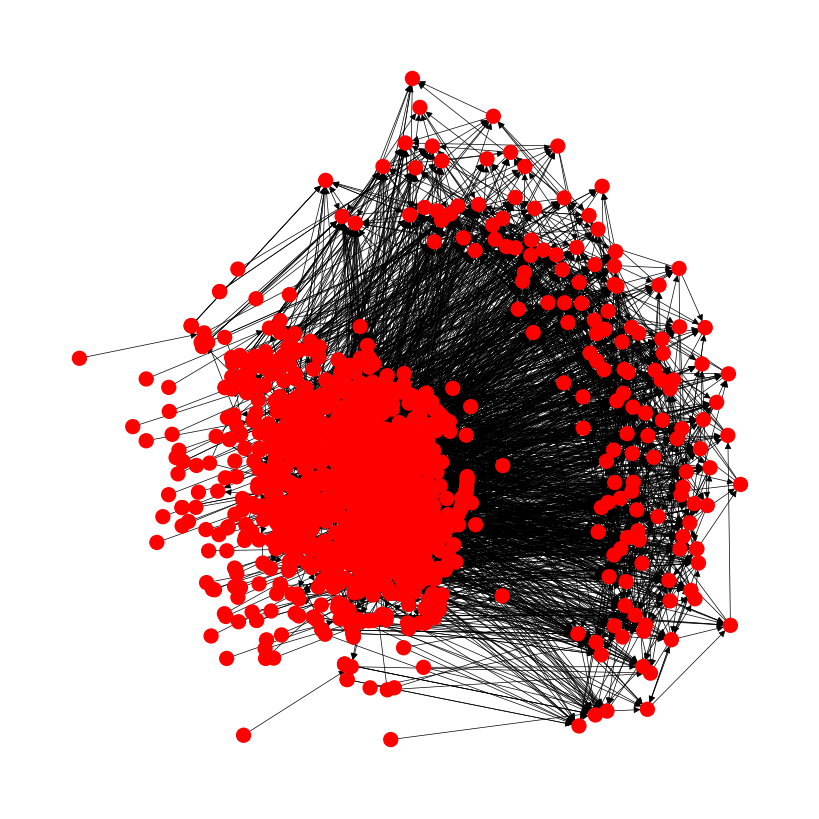

In [7]:
color_map = ["red"] * n
plt.figure(figsize=(8, 8))
nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.savefig("data/02preparation_graph.png")
plt.show()

頂点数：1500、辺数：3237
平均次数：2.158、最大次数：43


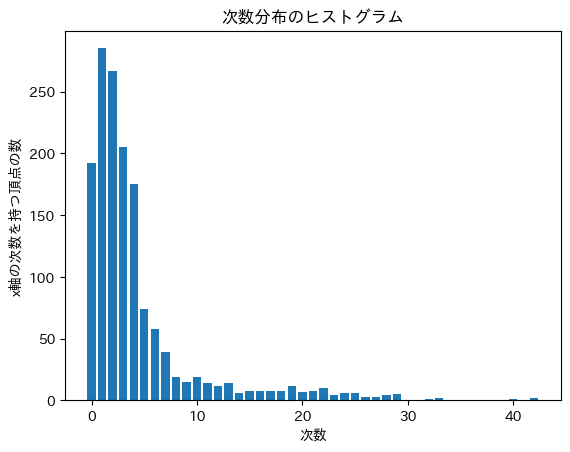

In [8]:
hist = nx.degree_histogram(G)
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")

plt.bar(range(len(hist)), hist)
plt.title("次数分布のヒストグラム")
plt.xlabel("次数")
plt.ylabel("x軸の次数を持つ頂点の数")
plt.savefig("data/02degree_histogram.png")
plt.show()

## ③グラフの成長
### (2)交換の応答

#### 類似性による共感や同調
- 次数相関
- 属性の類似性
    - グループ
    - NFTの興味

#### 一般的信頼
- 信用できる人65%、信用できない人35%で応じる
- 場面想定法ではポジティブな情報が一つの場合50%程度から60~~65%の信頼できる人を評価する、逆にネガティブな情報の場合は50%から30~35%の確立で評価するように変化する
<!-- 信頼できる人間同士だと60%、信頼できる or 信頼できない人間だと30%、信頼できない人間同士だと5%の確立で辺をつなぎ返す -->

In [9]:
for edge in G.edges():
    myself = edge[0]
    target = edge[1]
    sim = 0
    p = 0.35

    # 類似性の探索
    for col in ["group", "nft"]:
        if df.loc[myself, col] == df.loc[target, col]:
            sim += 1

    # 高信頼者 or 低信頼者の判定
    if (sim == 2):
        if (df["trust"][target] == 1):
            p = 0.70
        else:
            p = 0.65
    elif (sim == 1):
        if (df["trust"][target] == 1):
            p = 0.65
        else:
            p = 0.60
        
    if random() < p:
        G.add_edge(target, myself)


### NFTを返した後の結果の表示

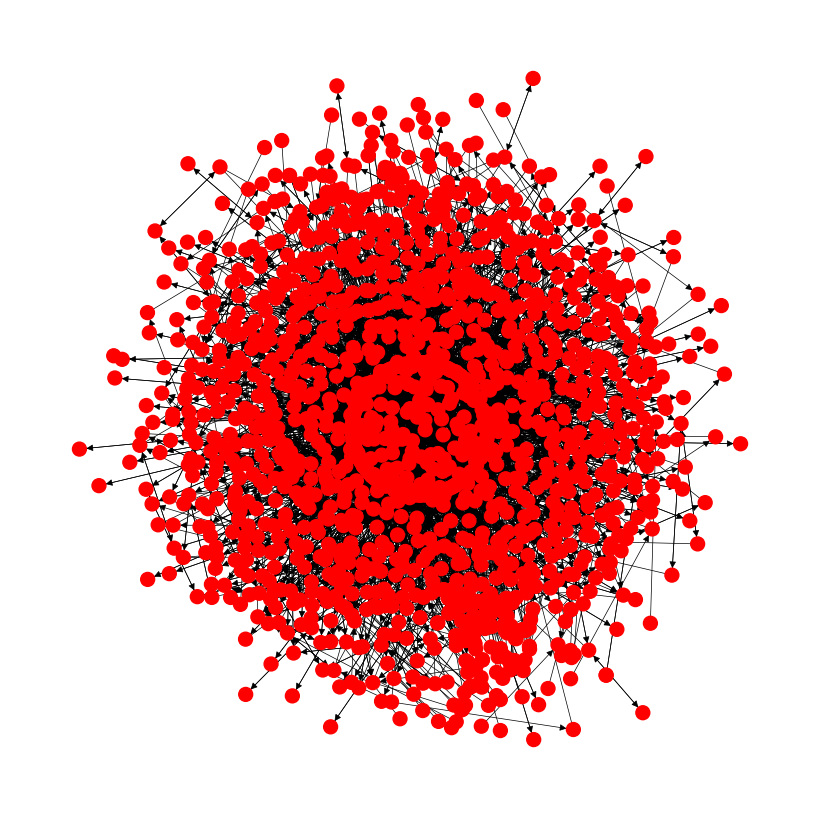

In [10]:
# グラフの表示と保存
color_map = ["red"] * n
plt.figure(figsize=(8, 8))   
nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.savefig("data/03after_graph.png")
plt.show()

頂点数：1500、辺数：4728
平均次数：3.152、最大次数：67


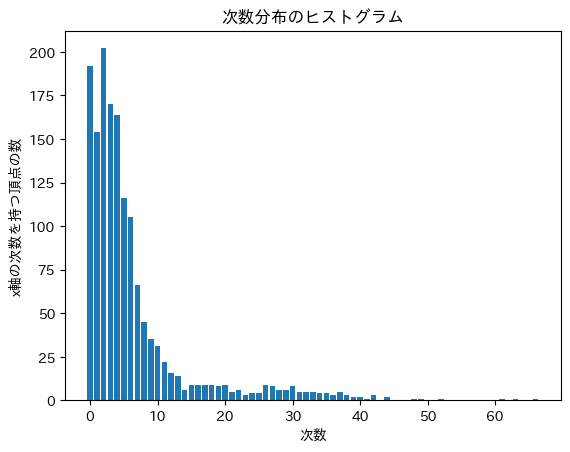

In [11]:
hist = nx.degree_histogram(G)
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")

plt.bar(range(len(hist)), hist)
plt.title("次数分布のヒストグラム")
plt.xlabel("次数")
plt.ylabel("x軸の次数を持つ頂点の数")
plt.savefig("data/03degree_histogram.png")
plt.show()

# ソーシャルグラフからスコアを求める

## 有向グラフから無向グラフへ変換
- オーソリティ中心性を求める

In [12]:
# 隣接行列の作成
A = nx.adjacency_matrix(G).todense()
AT = A.transpose()

In [13]:
# 共引用
GC = nx.DiGraph()
GC.add_nodes_from([i for i in range(n)])
M = np.dot(AT, A)
M = M - np.diag(np.diag(M))
for i, row in enumerate(M):
    for j, n in enumerate(row):
        if(n > 0):
            GC.add_edge(i, j)

In [14]:
print("無向グラフの頂点数：", GC.number_of_nodes())
print("無向グラフの辺数：", GC.number_of_edges())

無向グラフの頂点数： 1500
無向グラフの辺数： 25672


## 中心性からスコアを求める
|アルゴリズム名|信用の項目|詳細|
|-------------|-----------|---|
|次元中心性|個別的信用|どれだけ多くの人から信用を受けているのか(ローカル)|
|近傍中心性|×|辺の重みは関係性が低いため|
|媒介中心性|△|経由量は関係性が低いため|
|固有ベクトル中心性|×|多重グラフは利用できないため|
|Katz中心性|×|多重グラフは利用できないため|
|PageRank|個別的信頼|どれだけ多くの人から信用を受けているのか(グローバル)|

In [15]:
def print_centrality(v):
    for key in v:
        print("{:3}：{:<7}".format(key, round(v[key], 5)), end=(" " if (key+1)%5 else "\n"))
    print("")
    print("MAX：", np.argmax(list(v.values())))

def calc_score(v, name):
    temp = np.zeros(len(v))
    for key in v:
        temp[key] = v[key]
    df[name] = temp
    df["score"] += temp

### 次数中心性

In [16]:
v = nx.in_degree_centrality(G)
print_centrality(v)
calc_score(v, "次数中心性")

  0：0.01334   1：0.00734   2：0.00934   3：0.006     4：0.01134
  5：0.01468   6：0.01868   7：0.01534   8：0.02068   9：0.00667
 10：0.01334  11：0.00801  12：0.01668  13：0.02068  14：0.01001
 15：0.01534  16：0.01268  17：0.00934  18：0.00734  19：0.01201
 20：0.01601  21：0.01401  22：0.01067  23：0.00734  24：0.01268
 25：0.01401  26：0.00667  27：0.00734  28：0.01268  29：0.00734
 30：0.01401  31：0.00334  32：0.01468  33：0.01067  34：0.004  
 35：0.00534  36：0.00667  37：0.01201  38：0.00801  39：0.01734
 40：0.00267  41：0.01067  42：0.02535  43：0.00867  44：0.01134
 45：0.01067  46：0.01268  47：0.00801  48：0.006    49：0.01268
 50：0.00334  51：0.01468  52：0.01067  53：0.00667  54：0.01201
 55：0.006    56：0.01401  57：0.01334  58：0.00867  59：0.00667
 60：0.00801  61：0.01468  62：0.01334  63：0.00934  64：0.006  
 65：0.01268  66：0.01401  67：0.00667  68：0.01401  69：0.02668
 70：0.01001  71：0.00867  72：0.01201  73：0.01134  74：0.01668
 75：0.01734  76：0.02468  77：0.00667  78：0.01001  79：0.01201
 80：0.01334  81：0.00534  82：0.01668  83：

KeyError: 'score'

### 媒介中心性

In [17]:
v = nx.betweenness_centrality(G)
print_centrality(v)
calc_score(v, "媒介中心性")

  0：0.01455   1：0.00566   2：0.00911   3：0.0026    4：0.01014
  5：0.01781   6：0.0196    7：0.01684   8：0.02754   9：0.00237
 10：0.01126  11：0.00909  12：0.0175   13：0.03092  14：0.0081 
 15：0.01315  16：0.0083   17：0.00654  18：0.00413  19：0.00752
 20：0.02168  21：0.01224  22：0.00846  23：0.00737  24：0.00811
 25：0.00996  26：0.00825  27：0.00453  28：0.0126   29：0.00559
 30：0.016    31：0.00162  32：0.01249  33：0.0102   34：0.00146
 35：0.00095  36：0.00411  37：0.01037  38：0.00443  39：0.0162 
 40：0.00176  41：0.01104  42：0.02826  43：0.00585  44：0.00947
 45：0.00982  46：0.01052  47：0.0063   48：0.00431  49：0.01074
 50：0.00293  51：0.01133  52：0.01137  53：0.00486  54：0.00971
 55：0.00343  56：0.01555  57：0.00987  58：0.00469  59：0.00642
 60：0.00905  61：0.01585  62：0.01113  63：0.00755  64：0.0038 
 65：0.00971  66：0.02172  67：0.00349  68：0.01409  69：0.0311 
 70：0.00839  71：0.00893  72：0.00815  73：0.00704  74：0.01289
 75：0.01521  76：0.03589  77：0.00453  78：0.00519  79：0.00884
 80：0.00964  81：0.00576  82：0.01809  83：

KeyError: 'score'

### PageRank

In [19]:
v = nx.pagerank(G, max_iter=1000)
print_centrality(v)
calc_score(v, "PageRank")

  0：0.0037    1：0.00224   2：0.00267   3：0.00172   4：0.00341
  5：0.00414   6：0.00453   7：0.0037    8：0.00676   9：0.00176
 10：0.00402  11：0.00261  12：0.00476  13：0.00618  14：0.00258
 15：0.00424  16：0.00332  17：0.00262  18：0.0018   19：0.00306
 20：0.00467  21：0.00432  22：0.00334  23：0.00219  24：0.00342
 25：0.00432  26：0.0021   27：0.00227  28：0.0035   29：0.00233
 30：0.00326  31：0.0011   32：0.00382  33：0.00296  34：0.00101
 35：0.00173  36：0.00232  37：0.0037   38：0.00226  39：0.00504
 40：0.00102  41：0.00333  42：0.00684  43：0.00272  44：0.00318
 45：0.00283  46：0.00302  47：0.00229  48：0.00192  49：0.00314
 50：0.00113  51：0.00475  52：0.00329  53：0.00199  54：0.00325
 55：0.00175  56：0.00397  57：0.00319  58：0.00333  59：0.0025 
 60：0.00275  61：0.00402  62：0.00436  63：0.00287  64：0.00179
 65：0.00343  66：0.00374  67：0.00251  68：0.00366  69：0.00726
 70：0.00245  71：0.00264  72：0.00361  73：0.00339  74：0.00399
 75：0.00501  76：0.00726  77：0.00258  78：0.00292  79：0.00384
 80：0.00345  81：0.00195  82：0.00469  83：

KeyError: 'score'

## 最終結果
- 度数分布
- 箱ひげ図
- 次数分布
- 各属性を色分けしたグラフ
    - 高信頼者 or 低信頼者
    - グループ
    - 共通の関心があるか

### 標準偏差

In [20]:
n = len(df)
print("平均値")
print(df[["次数中心性", "媒介中心性", "PageRank"]].mean(numeric_only=True))
print("-" * 50)

print("標準偏差")
print(df[["次数中心性", "媒介中心性", "PageRank"]].std(numeric_only=True))
print("-" * 50)

print("最大値")
print(df[["次数中心性", "媒介中心性", "PageRank"]].max(numeric_only=True))
print("-" * 50)

print("最小値")
print(df[["次数中心性", "媒介中心性", "PageRank"]].min(numeric_only=True))

平均値
次数中心性       0.002103
媒介中心性       0.001421
PageRank    0.000667
dtype: float64
--------------------------------------------------
標準偏差
次数中心性       0.003481
媒介中心性       0.003519
PageRank    0.000951
dtype: float64
--------------------------------------------------
最大値
次数中心性       0.026684
媒介中心性       0.035891
PageRank    0.007258
dtype: float64
--------------------------------------------------
最小値
次数中心性       0.000000
媒介中心性       0.000000
PageRank    0.000112
dtype: float64


### 度数分布

In [21]:
bins = np.arange(0.00, 0.07, 0.01)
ex_l = [[] for i in range(len(bins)-1)]
ex = {
    "次数中心性": [[] for i in range(len(bins)-1)],
    "媒介中心性": [[] for i in range(len(bins)-1)],
    "PageRank": [[] for i in range(len(bins)-1)]
}

for i, data in enumerate(df.values.tolist()):
    for j in range(len(bins)-1):
        if (bins[j] < df.loc[i, "次数中心性"]) and (df.loc[i, "次数中心性"] < bins[j+1]):
            if len(ex["次数中心性"][j]) > 4:
                continue
            ex["次数中心性"][j].append(i)
        if (bins[j] < df.loc[i, "媒介中心性"]) and (df.loc[i, "媒介中心性"] < bins[j+1]):
            if len(ex["媒介中心性"][j]) > 4:
                continue
            ex["媒介中心性"][j].append(i)
        if (bins[j] < df.loc[i, "PageRank"]) and (df.loc[i, "PageRank"] < bins[j+1]):
            if len(ex["PageRank"][j]) > 4:
                continue
            ex["PageRank"][j].append(i)

for score in ["次数中心性", "媒介中心性", "PageRank"]:
    freq = df[score].value_counts(bins=bins, sort=False)
    rel_freq = freq / df[score].count()
    cum_freq = freq.cumsum()
    
    freq_df = pd.DataFrame(
        {
            "度数": freq,
            "相対度数": rel_freq,
            "累積度数": cum_freq,
            "例": ex[score]
        },
        index=freq.index
    )

    print(score)
    print(freq_df)
    print("-"*50)

次数中心性
                  度数      相対度数  累積度数                    例
(-0.001, 0.01]  1411  0.940667  1411     [1, 2, 3, 9, 11]
(0.01, 0.02]      84  0.056000  1495      [0, 4, 5, 6, 7]
(0.02, 0.03]       5  0.003333  1500  [8, 13, 42, 69, 76]
(0.03, 0.04]       0  0.000000  1500                   []
(0.04, 0.05]       0  0.000000  1500                   []
(0.05, 0.06]       0  0.000000  1500                   []
(0.06, 0.07]       0  0.000000  1500                   []
--------------------------------------------------
媒介中心性
                  度数      相対度数  累積度数                    例
(-0.001, 0.01]  1443  0.962000  1443     [1, 2, 3, 9, 11]
(0.01, 0.02]      47  0.031333  1490      [0, 4, 5, 6, 7]
(0.02, 0.03]       7  0.004667  1497  [8, 20, 42, 66, 90]
(0.03, 0.04]       3  0.002000  1500         [13, 69, 76]
(0.04, 0.05]       0  0.000000  1500                   []
(0.05, 0.06]       0  0.000000  1500                   []
(0.06, 0.07]       0  0.000000  1500                   []
---------

### 箱ひげ図
- すべて
- 次元中心性
- 媒介中心性
- PageRank

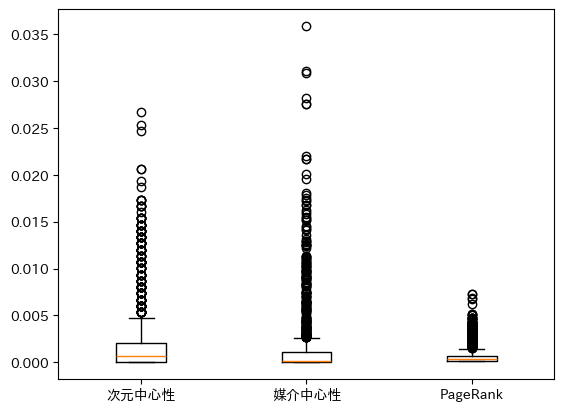

In [22]:
# 各中心性の箱ひげ図
# df[["次数中心性", "媒介中心性", "PageRank"]].boxplot(patch_artist = True, labels=["Degree", "Between", "PageRank"])
plt.boxplot(df[["次数中心性", "媒介中心性", "PageRank"]], labels=["次元中心性", "媒介中心性", "PageRank"])
# plt.title("各スコアの箱ひげ図")
# plt.set_xticklabels(['一様分布', '正規分布'])
# plt.xticks(["Degree", "Between", "PageRank"])
plt.savefig("data/result/box_diagram.png")
plt.show()

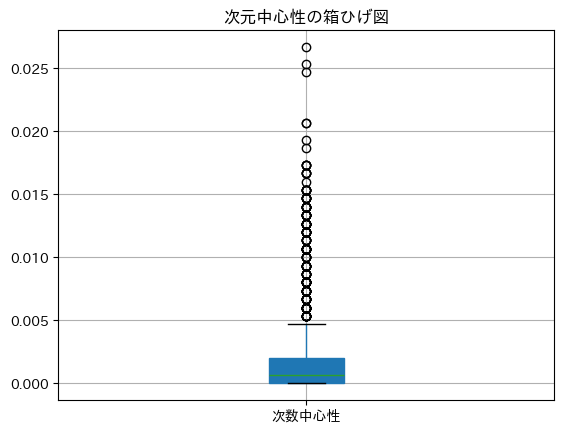

In [23]:
# 次元中心性の箱ひげ図
df[["次数中心性"]].boxplot(patch_artist = True)
plt.title("次元中心性の箱ひげ図")
plt.savefig("data/result/dc_box_diagram.png")
plt.show()

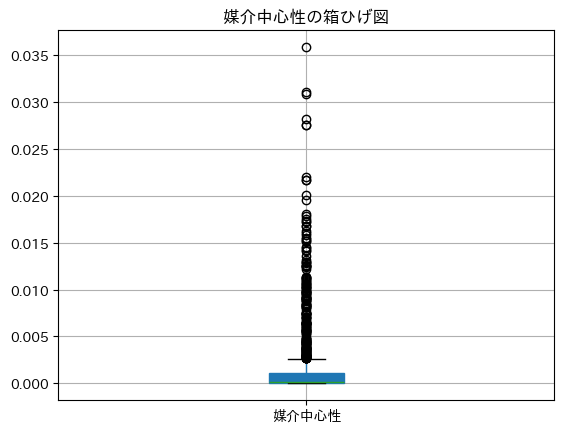

In [24]:
# 媒介中心性の箱ひげ図
df[["媒介中心性"]].boxplot(patch_artist = True)
plt.title("媒介中心性の箱ひげ図")
plt.savefig("data/result/bc_box_diagram.png")
plt.show()

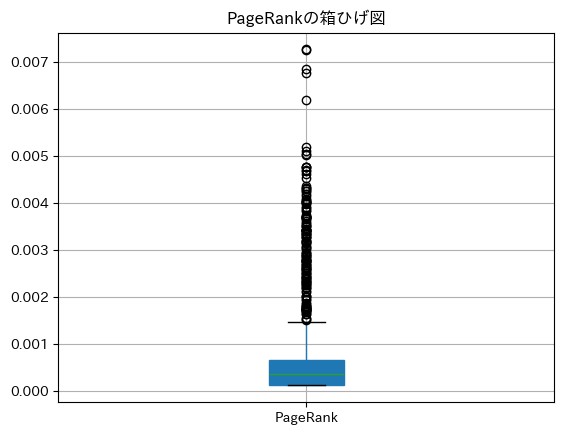

In [25]:
# PageRankの箱ひげ図
df[["PageRank"]].boxplot(patch_artist = True)
plt.title("PageRankの箱ひげ図")
plt.savefig("data/result/pr_box_diagram.png")
plt.show()

### 次数分布

In [26]:
df.to_csv("data/data.csv")
print("# 次元中心性")
print(df.sort_values("次数中心性").head())
print("# 媒介中心性")
print(df.sort_values("媒介中心性").head())
print("# PageRank")
print(df.sort_values("PageRank").head())

# 次元中心性
      trust  group  nft  次数中心性  媒介中心性  PageRank
1499      1      1    4    0.0    0.0  0.000112
487       1      3    0    0.0    0.0  0.000112
490       0      3    0    0.0    0.0  0.000112
493       0      3    4    0.0    0.0  0.000112
498       0      2    2    0.0    0.0  0.000112
# 媒介中心性
      trust  group  nft     次数中心性  媒介中心性  PageRank
1499      1      1    4  0.000000    0.0  0.000112
528       1      2    4  0.000667    0.0  0.000362
1069      0      0    0  0.000667    0.0  0.000291
531       0      2    1  0.000000    0.0  0.000112
532       0      1    2  0.000667    0.0  0.000370
# PageRank
      trust  group  nft  次数中心性  媒介中心性  PageRank
1499      1      1    4    0.0    0.0  0.000112
553       1      2    3    0.0    0.0  0.000112
1180      1      0    0    0.0    0.0  0.000112
1179      1      0    1    0.0    0.0  0.000112
560       1      1    4    0.0    0.0  0.000112


頂点数：1500、辺数：4728
平均次数：3.152、最大次数：67


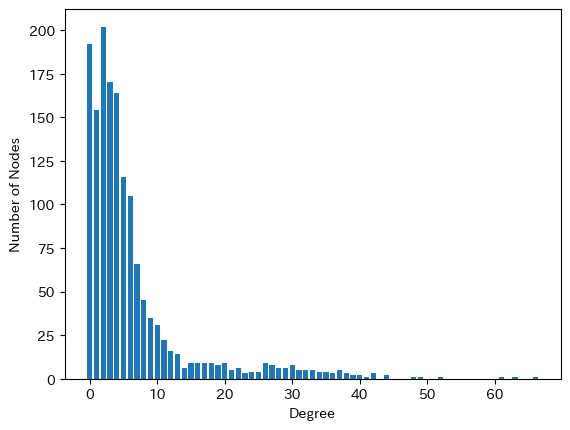

In [27]:
hist = nx.degree_histogram(G)
print(f"頂点数：{G.number_of_nodes()}、辺数：{G.number_of_edges()}")
print(f"平均次数：{G.number_of_edges()/G.number_of_nodes()}、最大次数：{len(hist)}")

plt.bar(range(len(hist)), hist)
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.savefig("data/result/degree_histogram.png")
plt.show()

### グラフ
- 高信頼者 or 低信頼者
- グループ
- 共通の関心があるか

In [28]:
pos = nx.kamada_kawai_layout(G)

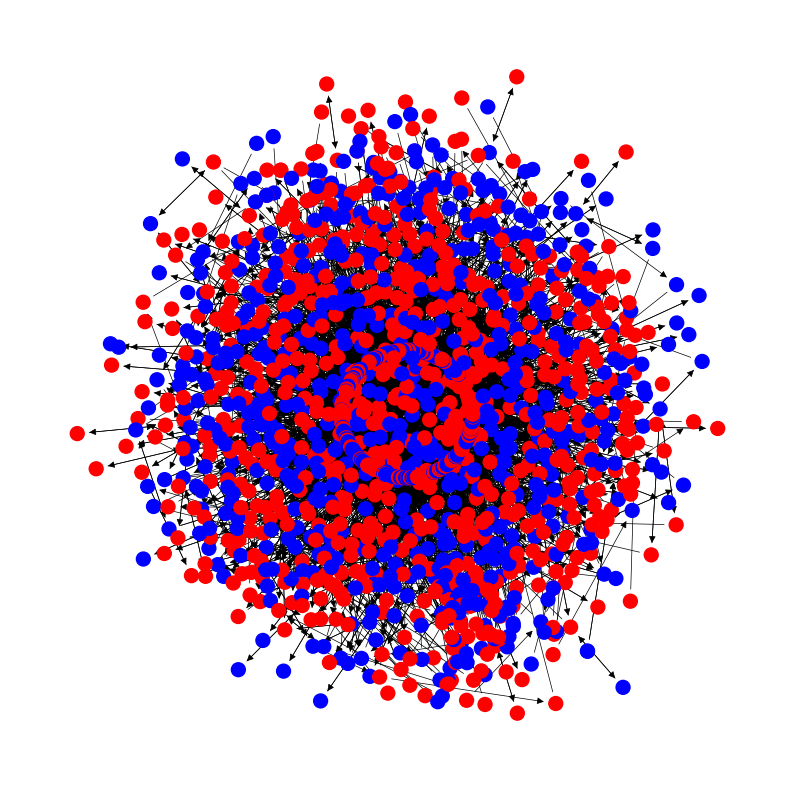

In [29]:
# 高信頼者 or 低信頼者
# 頂点の色を選択
color_map = ["black"] * len(df)
for i, d in enumerate(df["trust"]):
    color_map[i] = color[d]

# グラフの表示と保存
# nx.draw_kamada_kawai(G, node_size=100, node_color=color_map, with_labels=False, width=0.5)
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
plt.axis("off")
plt.savefig("data/result/trust_graph.png")
plt.show()

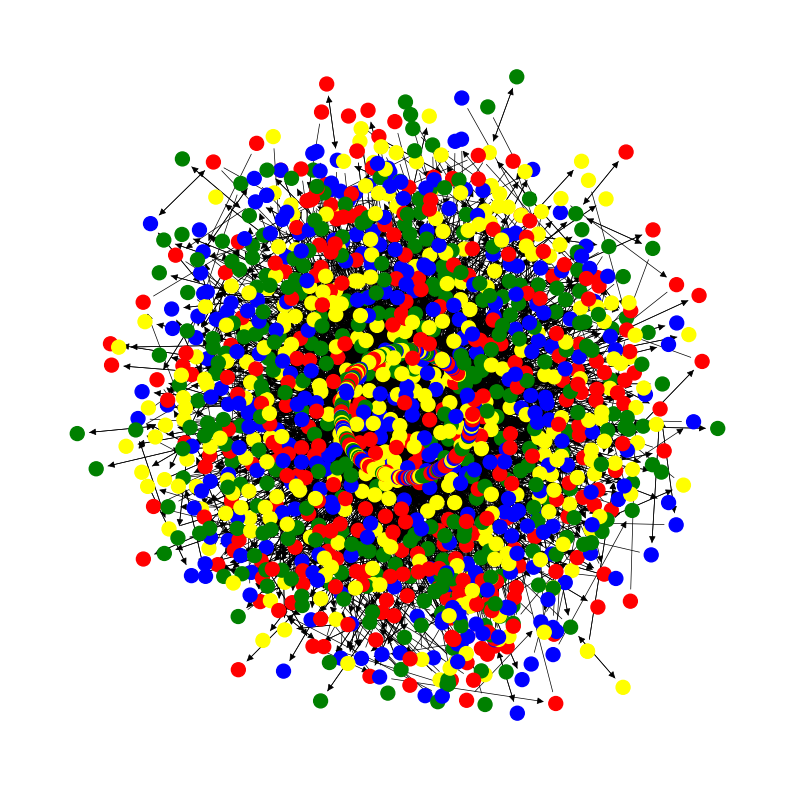

In [30]:
# グループ
# 頂点の色を選択
color_map = ["black"] * len(df)
for i, d in enumerate(df["group"]):
    color_map[i] = color[d]

# グラフの表示と保存
plt.figure(figsize=(10, 10))   
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
plt.axis("off")
plt.savefig("data/result/group_graph.png")
plt.show()

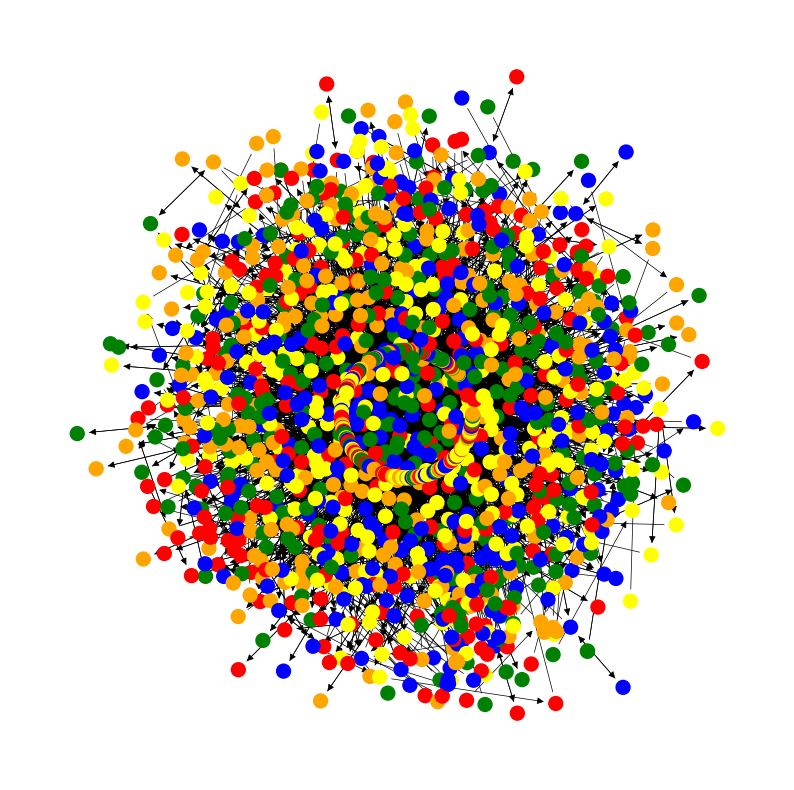

In [31]:
# 共通の関心があるか
# 頂点の色を選択
color_map = ["black"] * len(df)
for i, d in enumerate(df["nft"]):
    color_map[i] = color[d]

# グラフの表示と保存
plt.figure(figsize=(10, 10)) 
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map)
plt.axis("off")
plt.savefig("data/result/nft_graph.png")
plt.show()

## グループの抽出

In [32]:
color = ["red", "orange", "yellow", "green", "blue", "purple", "gray"]
lst_m = greedy_modularity_communities(G)
color_map_m = ["black"] * G.number_of_nodes()
for counter, c in enumerate(lst_m):
    for n in c:
        try:
            color_map_m[n] = color[counter]
        except:
            color_map_m[n] = color_map_m[n]

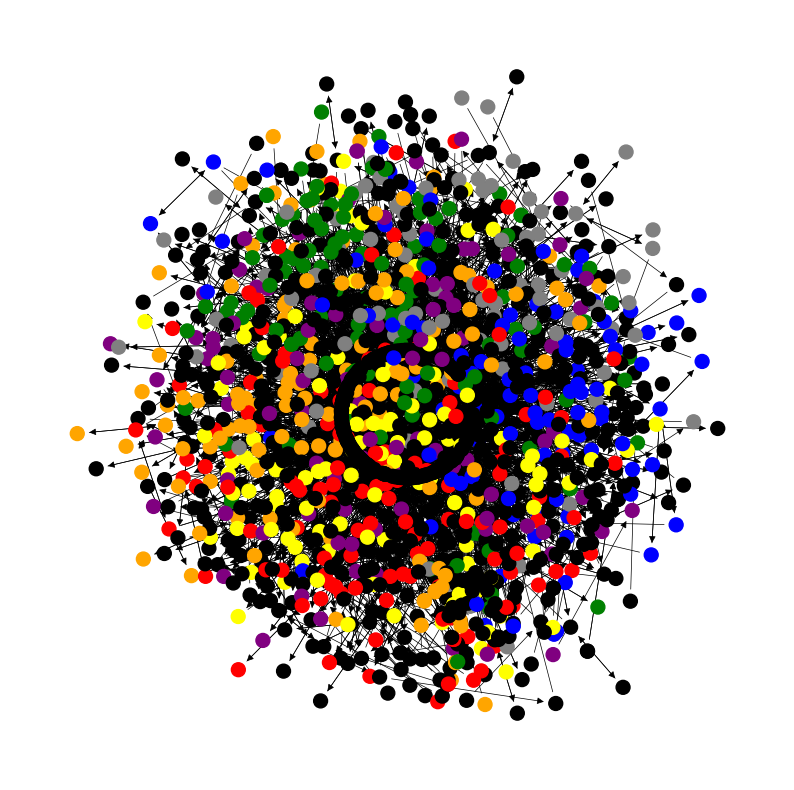

In [33]:
plt.figure(figsize=(10, 10)) 
nx.draw_networkx_edges(G, pos, width=0.5)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=color_map_m)
plt.axis("off")
plt.savefig("data/result/extraction_graph.png")
plt.show()

In [34]:
df[["次数中心性", "媒介中心性", "PageRank"]].to_csv("data/score.csv")